## Постановка задачи

Нам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. В базе обсерватории есть характеристики уже изученных 240 звёзд.

Целевая метрика - RMSE. Она не должна превышать 4500.

## Загрузка данных

In [1]:
!pip install category_encoders

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
import torch 
import torch.nn as nn

from math import ceil
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [3]:
df = pd.read_csv('/datasets/6_class.csv')
df = df.drop(columns=df.columns[0], axis=1)
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


В нашем распоряжении следующие данные:

- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах. Целевой признак.
- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Тип звезды:

| Тип звезды	|Номер, соответствующий типу |
|-------------------------------------|----------------|
|Коричневый карлик |	0|
|Красный карлик |	1|
|Белый карлик | 	2|
|Звёзды главной последовательности | 	3|
|Сверхгигант| 	4|
|Гипергигант|	5|

- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [5]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


В нашем распоряжении датасет на 240 записей. Пропусков нет. Датасет содержит 6 признаков, 2 из которых (тип звезды и звёздный цвет) - категориальные. 

## Предобработка и анализ данных

### Дубликаты

In [6]:
# Проверим записи на дубликаты
df.duplicated().sum()

0

Дубликаты отсутствуют.

### Анализ признаков

#### `Temperature (K)`

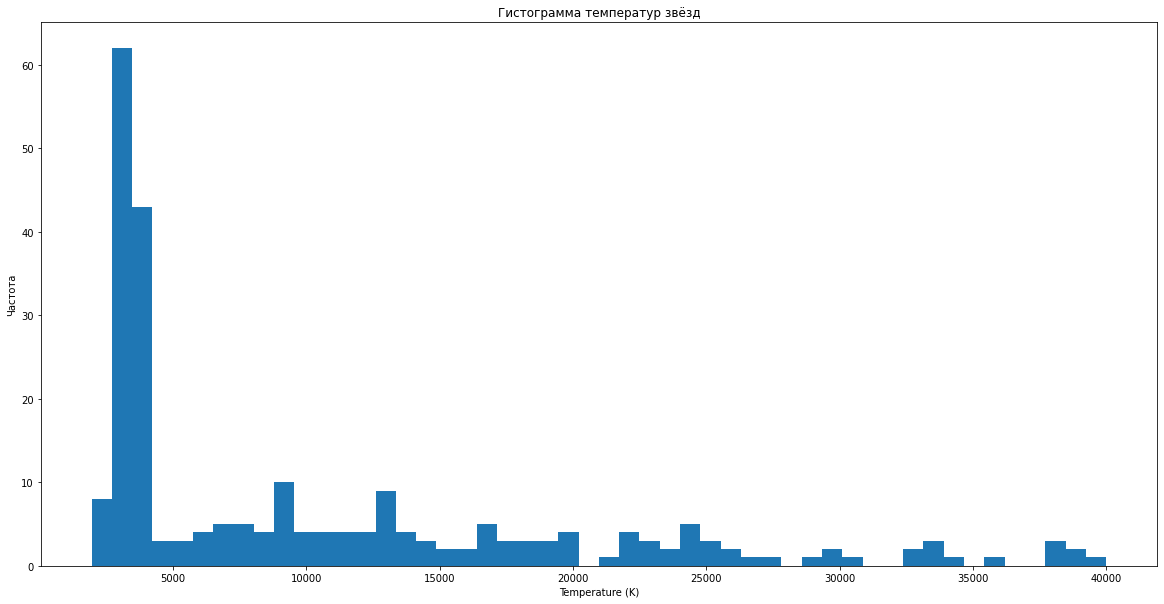

In [7]:
ax = df['Temperature (K)'].plot.hist(bins=50, figsize=(20, 10), title='Гистограмма температур звёзд')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Частота')

plt.show()

In [8]:
df['Temperature (K)'].describe()

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: Temperature (K), dtype: float64

По гистограмме и описательной статистике хорошо видно, что в датасете преобладают звезды с температурой, близкой к 5000 К.

Температура звезд может достигать 300 кельвинов в минимуме([1](https://en.wikipedia.org/wiki/Stellar_classification#Class_Y)) и 6 миллиардов кельвинов в максимуме (теоретический предел([2](https://www.newscientist.com/article/mg20928026-300-eight-extremes-the-hottest-thing-in-the-universe/))). Считаем, что некорректные значения отсутствуют.

#### `Luminosity(L/Lo)`

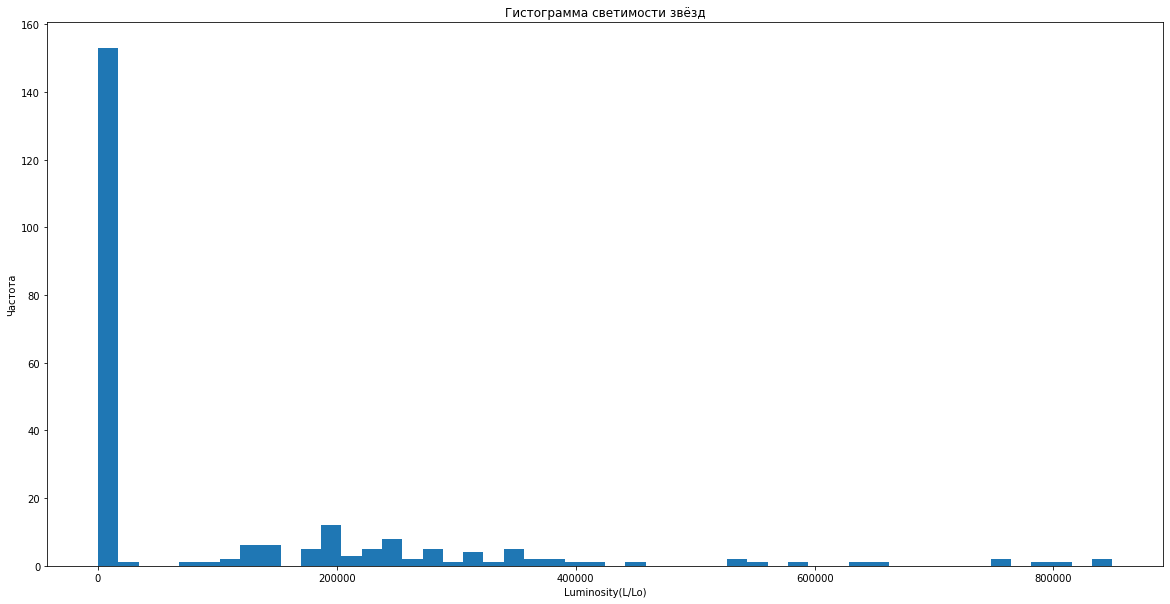

In [9]:
ax = df['Luminosity(L/Lo)'].plot.hist(bins=50, figsize=(20, 10), title='Гистограмма светимости звёзд')

ax.set_xlabel('Luminosity(L/Lo)')
ax.set_ylabel('Частота')

plt.show()

In [10]:
df['Luminosity(L/Lo)'].describe()

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64

По гистограмме и описательной статистике хорошо видно, что в датасете преобладают звезды со светимостью, гораздо ниже солнечной.

Светимость звезд может колебаться в очень широких пределах. [Самая тусклая известная звезда](https://en.wikipedia.org/wiki/2MASS_J09393548%E2%88%922448279) имеет светимость в 0.000002 L. [А самая яркая](https://en.wikipedia.org/wiki/Godzilla_(star)) - 134,000,000–255,000,000 L. Считаем, что некорректные значения отсутствуют.

#### `Radius(R/Ro)`

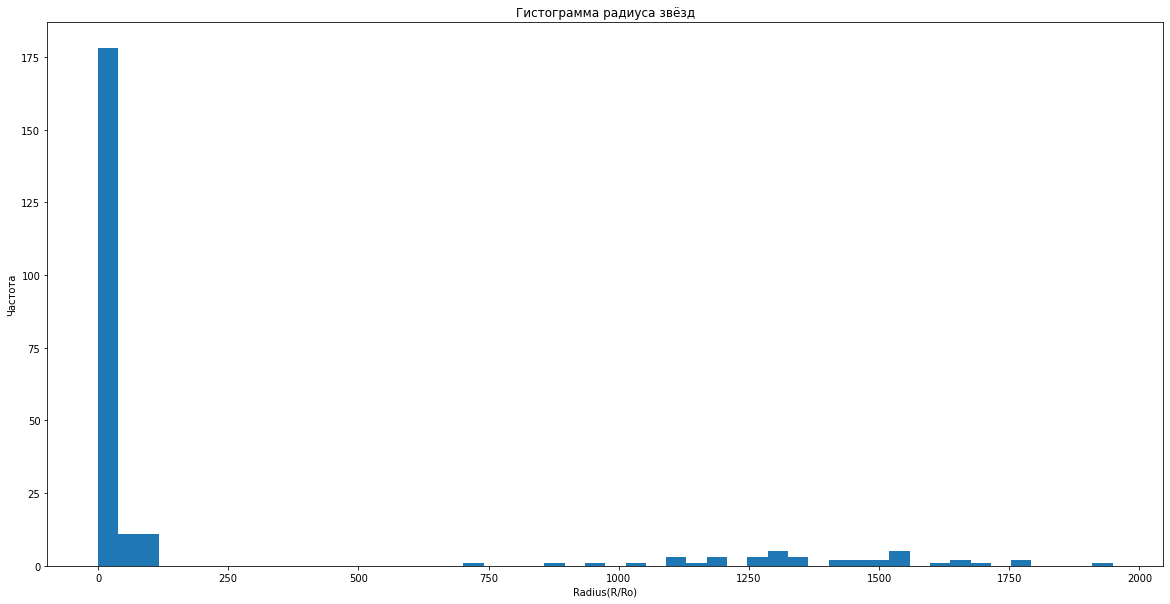

In [11]:
ax = df['Radius(R/Ro)'].plot.hist(bins=50, figsize=(20, 10), title='Гистограмма радиуса звёзд')

ax.set_xlabel('Radius(R/Ro)')
ax.set_ylabel('Частота')

plt.show()

In [12]:
df['Radius(R/Ro)'].describe()

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64

По гистограмме и описательной статистике видно, что преобладают звёзды с радиусом, близким к солнечному.

Радиус звёзд может колебаться от нескольких километров (нейтронные звёзды) до сотен миллионов километров (напр. UY Scuti c примерным радиусом в 1708 R). Некорректных данных нет.

#### `Absolute magnitude(Mv)`

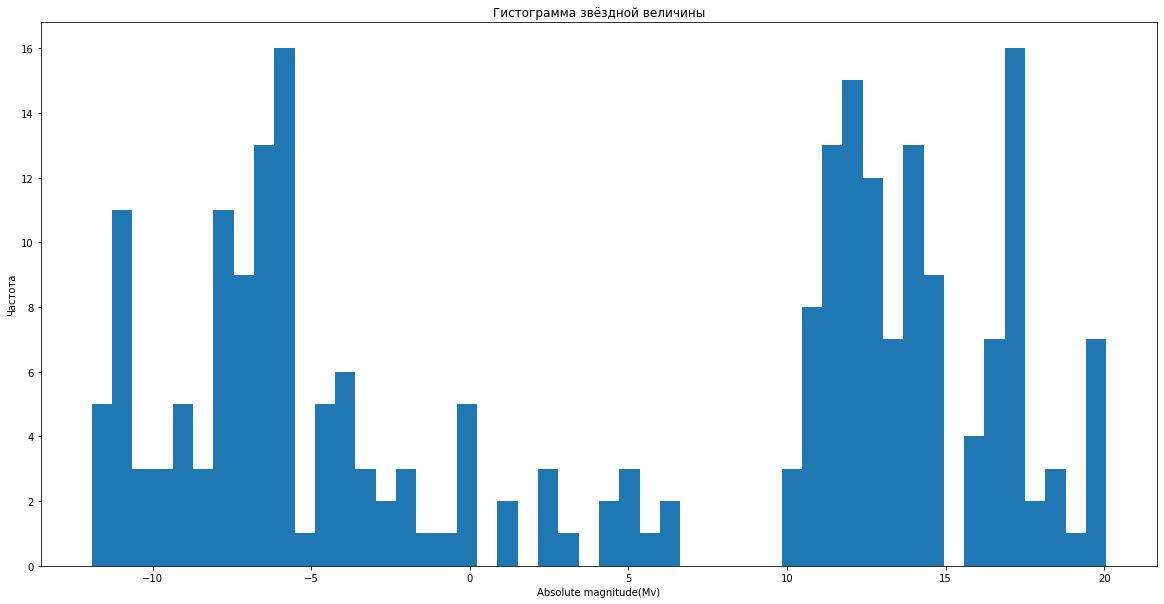

In [13]:
ax = df['Absolute magnitude(Mv)'].plot.hist(bins=50, figsize=(20, 10), title='Гистограмма звёздной величины')

ax.set_xlabel('Absolute magnitude(Mv)')
ax.set_ylabel('Частота')

plt.show()

In [14]:
df['Absolute magnitude(Mv)'].describe()

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: Absolute magnitude(Mv), dtype: float64

Звездная величина в датасете имеет значения от -11.92 до 20.06. Этото укладывается в примерный диапазон, применимый к данному свойству ([Wiki](https://en.wikipedia.org/wiki/Absolute_magnitude)). Выбросов и некорректных значений не наблюдается.

#### `Star type`

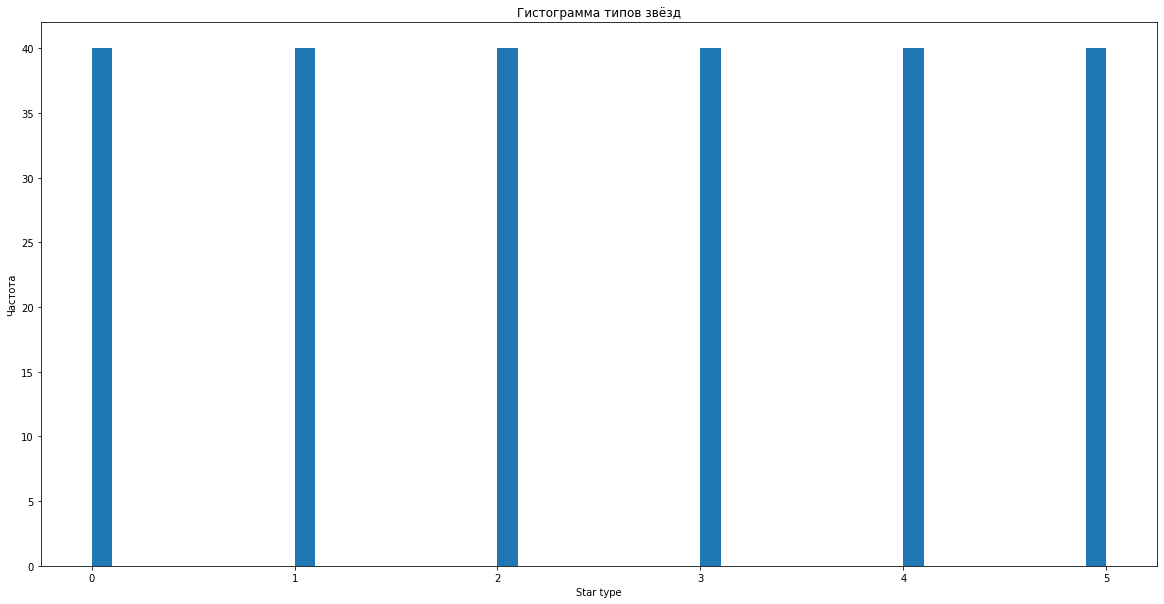

In [15]:
ax = df['Star type'].plot.hist(bins=50, figsize=(20, 10), title='Гистограмма типов звёзд')

ax.set_xlabel('Star type')
ax.set_ylabel('Частота')

plt.show()

In [16]:
df['Star type'].describe()

count    240.000000
mean       2.500000
std        1.711394
min        0.000000
25%        1.000000
50%        2.500000
75%        4.000000
max        5.000000
Name: Star type, dtype: float64

In [17]:
df['Star type'].unique()

array([0, 1, 2, 3, 4, 5])

Категориальный признак. Количество объектов одинаково в датасете для каждого типа звезды. Вероятно датасет специально составляли так, чтобы включить одинаковое количество типов звёзд.

#### `Star color`

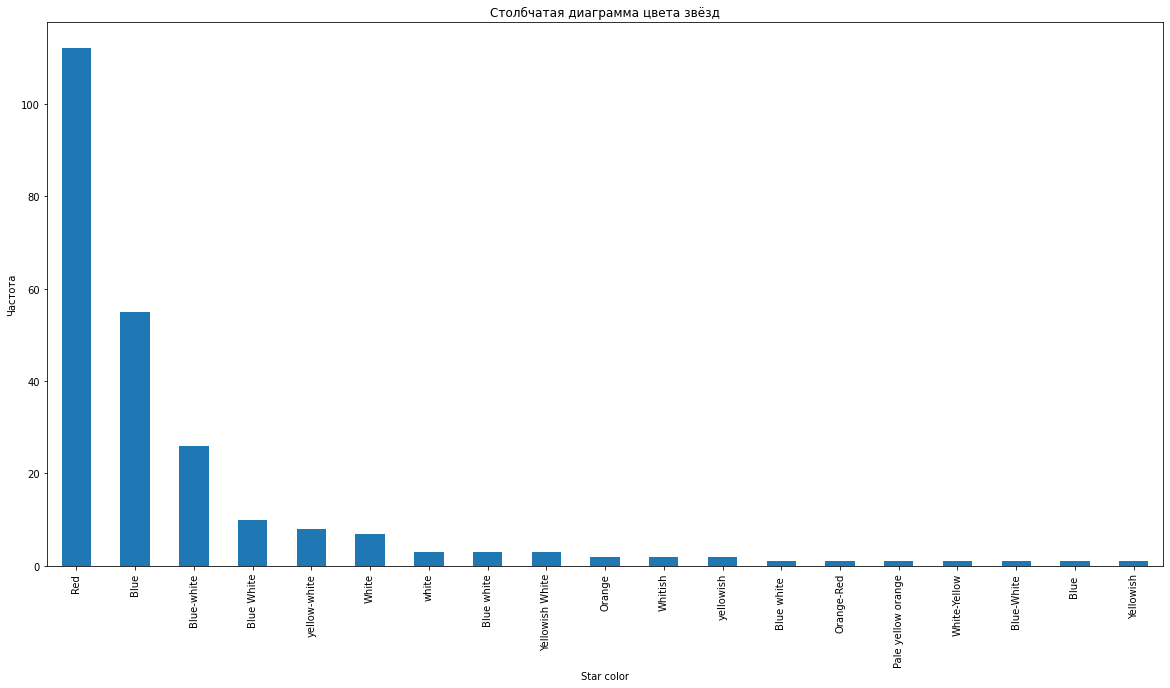

In [18]:
ax = df['Star color'].value_counts().plot.bar(figsize=(20, 10), title='Столбчатая диаграмма цвета звёзд')

ax.set_xlabel('Star color')
ax.set_ylabel('Частота')

plt.show()

In [19]:
df['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Blue white              3
Yellowish White         3
Orange                  2
Whitish                 2
yellowish               2
Blue white              1
Orange-Red              1
Pale yellow orange      1
White-Yellow            1
Blue-White              1
Blue                    1
Yellowish               1
Name: Star color, dtype: int64

In [20]:
df['Star color'].describe()

count     240
unique     19
top       Red
freq      112
Name: Star color, dtype: object

In [21]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Явно заметны ошибки в заполнении данного признака. Множество дубликатов, которые написаны немного по разному. На основе [Гарвардской классификации](https://en.wikipedia.org/wiki/Stellar_classification#Harvard_spectral_classification) попробуем унифицировать данный признак. Рекомендация на будущее: унифицировать ввод данных для данного признака, используя одну из принятых классификаций. 

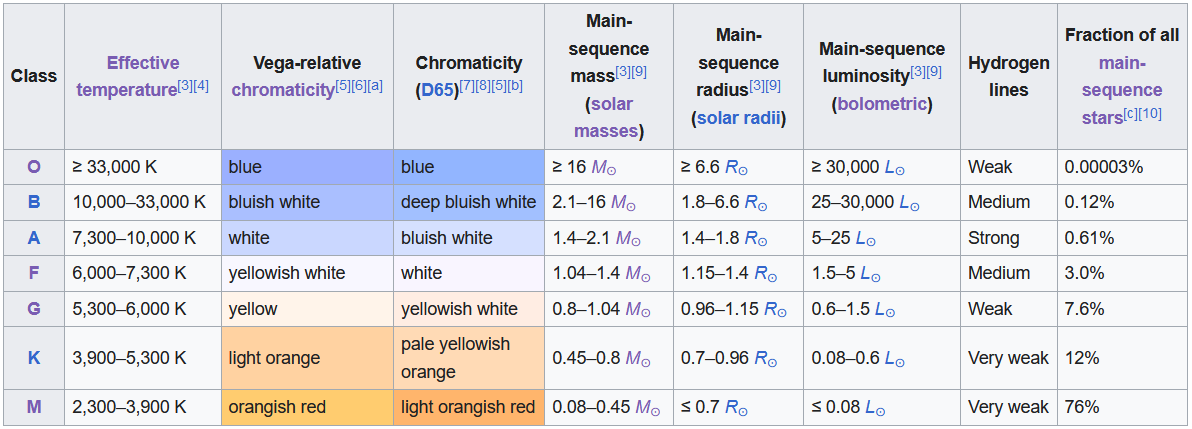

Сгруппируем значения следующим образом:

* Blue:
    * `'Blue', 'Blue '`
* Bluish white:
    * `'Blue White', 'Blue white', 'Blue-white', 'Blue white ', 'Blue-White'`
* White:
    * `'White', 'Whitish', 'white'`
* Yellowish white:
    * `'Yellowish White', 'yellow-white', 'White-Yellow'`
* Yellow:
    * `'yellowish', 'Yellowish'`
* Light orange:
    * `'Pale yellow orange'`
* Orangish red:
    * `'Red', 'Orange', 'Orange-Red'`

Так как температура звезды и её цвет имеют прямую связь, то данный признак является не категориальным, а количественным. Заменим текстовые обозначения на целочисленные, где в качестве `0` будут указаны синие звёзды (самые горячие), а в качестве `6` - красно-оранжевые звёзды (самые холодные).

In [22]:
# Функция в зависимости от цвета звезды возвращает число, соответствующее этому цвету.
def unify(row):
    if row['Star color'] in ['Blue', 'Blue ']:
        return 0
    if row['Star color'] in ['Blue White', 'Blue white', 'Blue-white', 'Blue white ', 'Blue-White']:
        return 1
    if row['Star color'] in ['White', 'Whitish', 'white']:
        return 2
    if row['Star color'] in ['Yellowish White', 'yellow-white', 'White-Yellow']:
        return 3
    if row['Star color'] in ['yellowish', 'Yellowish']:
        return 4
    if row['Star color'] in ['Pale yellow orange']:
        return 5
    if row['Star color'] in ['Red', 'Orange', 'Orange-Red']:
        return 6
    else:
        return 'unknown'

In [23]:
# Применяем функцию unify к нашему датасету
df['Star color'] = df.apply(unify, axis=1)
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,6
1,3042,0.000500,0.1542,16.60,0,6
2,2600,0.000300,0.1020,18.70,0,6
3,2800,0.000200,0.1600,16.65,0,6
4,1939,0.000138,0.1030,20.06,0,6


In [24]:
df['Star color'].describe()

count    240.000000
mean       3.366667
std        2.658950
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max        6.000000
Name: Star color, dtype: float64

In [25]:
df['Star color'].value_counts()

6    115
0     56
1     41
2     12
3     12
4      3
5      1
Name: Star color, dtype: int64

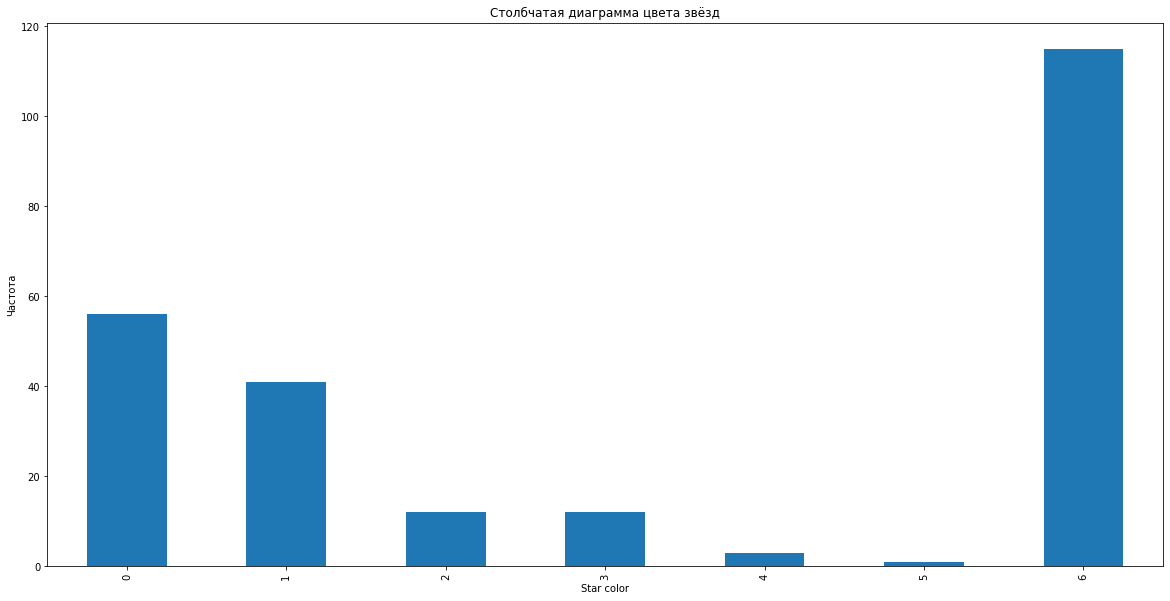

In [26]:
ax = df.groupby('Star color').count()['Star type'].plot(kind='bar', figsize=(20, 10), title='Столбчатая диаграмма цвета звёзд')

ax.set_xlabel('Star color')
ax.set_ylabel('Частота')

plt.show()

В результате мы изменили тип признака с категориального на количественный и сгруппировали значения.

#### Вывод

Были проведены анализ данных и предобработка данных. В результате установлено, что в большинстве своём признаки хоть и имеют большой разброс и неравномерность, но почти не имеют ошибочных значений. 

* `Temperature (K)`, `Luminosity(L/Lo)`, `Radius(R/Ro)`, `Absolute magnitude(Mv)`, `Star type` - данные признаки имеют корректные значения, несмотря на выбросы некоторых значений. Редактирования не проводилось, оставили все данные.
* Признак `Star type` имеет строго равномерное распределение в датасете. Датасет явно строился вокруг данного признака.
* Признак `Star color` имеет множество похожих, но по разному заполненных значений. Это было исправлено. Так же признак был приведён к количественному, т.к. имеется прямая связь между температурой звезды и её цветом.

### Разделение, кодирование и масштабирование данных 

#### Разделение выборок

In [27]:
X = df.drop('Temperature (K)', axis=1)
y = df['Temperature (K)']

In [28]:
X.head()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0.002400,0.1700,16.12,0,6
1,0.000500,0.1542,16.60,0,6
2,0.000300,0.1020,18.70,0,6
3,0.000200,0.1600,16.65,0,6
4,0.000138,0.1030,20.06,0,6


In [29]:
y.head()

0    3068
1    3042
2    2600
3    2800
4    1939
Name: Temperature (K), dtype: int64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=987654321)

#### Кодирование и масштабирование признаков

У нас имеется только один категориальный признак - `Star type`. Он содержит в себе 6 значений. Закодируем его с использованием One Hot Encoder.

In [31]:
cat_features = ['Star type']
num_features = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star color']

In [32]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [33]:
# Кодирование и масштабирование прризнаков
encoder = ce.one_hot.OneHotEncoder(cols=cat_features, return_df=True)

encoder.fit(X_train_copy)

X_train_copy = encoder.transform(X_train_copy)
X_test_copy = encoder.transform(X_test_copy)

scaler = StandardScaler()
scaler.fit(X_train_copy[num_features])

X_train_copy[num_features] = scaler.transform(X_train_copy[num_features])
X_test_copy[num_features] = scaler.transform(X_test_copy[num_features])

In [34]:
X_train_copy.head()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star type_6,Star color
221,1.116847,-0.316684,-1.059566,1,0,0,0,0,0,-1.349288
186,-0.610484,-0.463597,1.280020,0,1,0,0,0,0,0.939257
119,0.428449,2.099568,-1.411413,0,0,1,0,0,0,0.939257
139,-0.610484,-0.463332,0.981716,0,0,0,1,0,0,0.939257
126,-0.610484,-0.463647,1.225522,0,1,0,0,0,0,0.939257


In [35]:
X_test_copy.head()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star type_6,Star color
140,-0.610484,-0.463809,0.918613,0,0,0,0,0,1,-0.967864
201,-0.610484,-0.463806,0.751295,0,0,0,0,0,1,-1.349288
92,-0.610484,-0.462288,0.207080,0,0,0,0,1,0,0.176409
125,-0.610484,-0.463593,1.488451,0,1,0,0,0,0,0.939257
213,-0.575430,-0.450972,-0.632188,0,0,0,0,1,0,-0.967864


## Построение базовой нейронной сети

Построим три базовых нейронных сети и выберем среди них лучшию. Сети будут прямого распространения и с полносвязными слоями. Различаться сети будут количеством скрытых слоёв и количеством нейронов в них. Общие параметры сетей:

1. Функция активация для всех слоёв, за исключением выходного - ReLU. Для выходного слоя функция активации не применяется, т.к. модель будет решать задачу регрессии.
2. Для весов применяется инициализация Кайминга с параметрами `mode='fan_in', nonlinearity='relu'`. Смещение будет задано нормальным распределением с параметрами `mean=0.5, std=0.5`.

In [36]:
# Подготовим тензоры выборок
X_train_torch = torch.Tensor(X_train_copy.values)
X_test_torch = torch.Tensor(X_test_copy.values)
y_train_torch = torch.Tensor(y_train.values)

In [37]:
# Определение моделей
n_in_neurons = 10 

n_hidden_neurons_small_1 = 5
n_hidden_neurons_small_2 = 2

n_hidden_neurons_medium_1 = 5
n_hidden_neurons_medium_2 = 3
n_hidden_neurons_medium_3 = 2

n_hidden_neurons_large_1 = 5
n_hidden_neurons_large_2 = 4
n_hidden_neurons_large_3 = 3
n_hidden_neurons_large_4 = 2

n_out_neurons = 1 

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(layer.bias, mean=0.5, std=0.5)

net_small = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_small_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_small_1, n_hidden_neurons_small_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_small_2, n_out_neurons)
)

net_medium = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_medium_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_medium_1, n_hidden_neurons_medium_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_medium_2, n_hidden_neurons_medium_3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_medium_3, n_out_neurons)
)

net_large = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_large_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_large_1, n_hidden_neurons_large_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_large_2, n_hidden_neurons_large_3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_large_3, n_hidden_neurons_large_4),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_large_4, n_out_neurons)
)


display(net_small.apply(init_weights))
display(net_medium.apply(init_weights))
display(net_large.apply(init_weights))

Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=1, bias=True)
)

Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=1, bias=True)
)

Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=3, bias=True)
  (5): ReLU()
  (6): Linear(in_features=3, out_features=2, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2, out_features=1, bias=True)
)

In [38]:
# Функция обучения нейронных сетей
def net_learn(net, batch_size=64, num_epochs=1000, eval_epoch=10, learning_rate=1e-3):

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    loss = nn.MSELoss()

    num_batches = ceil(len(X_train_torch)/batch_size)
    
    train_values = []
    test_values = []

    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train_torch))

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train_torch[batch_indexes]
            y_batch = y_train_torch[batch_indexes]

            preds = net.forward(X_batch).flatten()

            loss_value = loss(preds, y_batch)

            loss_value.backward()

            optimizer.step()

        if epoch % eval_epoch == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test_torch)
            rmse = mean_squared_error(y_test, test_preds.detach().numpy(), squared=False)
            train_values.append((loss_value**0.5).detach().tolist())
            test_values.append(rmse)
    
    print(f'The last RMSE: {test_values[-1]}')
    
    plt.figure(figsize=(16,8))
    plt.plot(range(0, round((num_epochs/eval_epoch)+1)), train_values, label='Training Loss')
    plt.plot(range(0, round((num_epochs/eval_epoch)+1)), test_values, label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel(f'Epochs, x{eval_epoch}')
    plt.ylabel('Loss')
    plt.ylim(bottom=0)
    
    plt.legend(loc='best')
    plt.grid()
    plt.show()

The last RMSE: 13427.413301286613


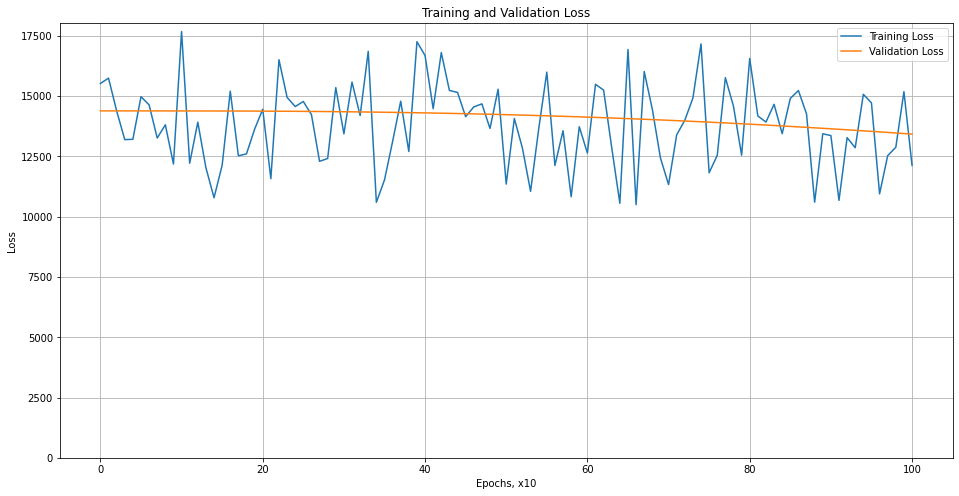

In [39]:
net_learn(net_small)

The last RMSE: 5711.702497695051


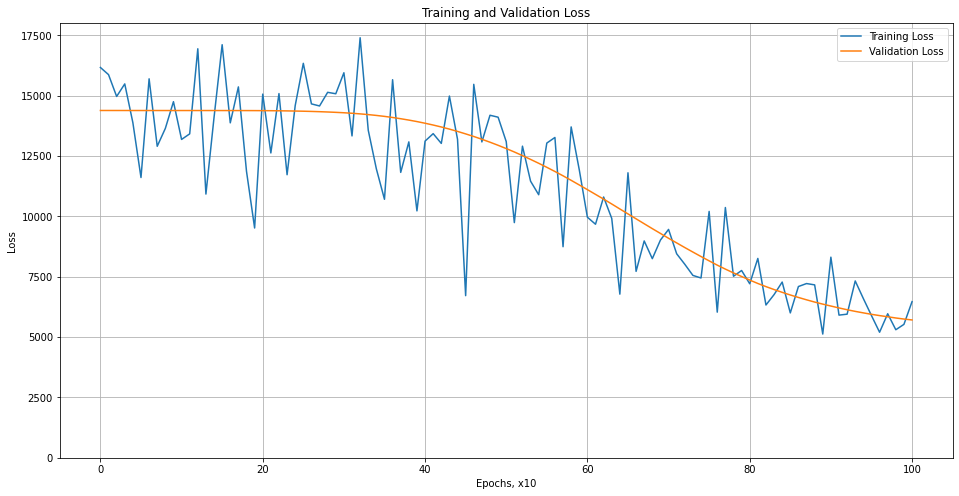

In [40]:
net_learn(net_medium)

The last RMSE: 5049.877755232894


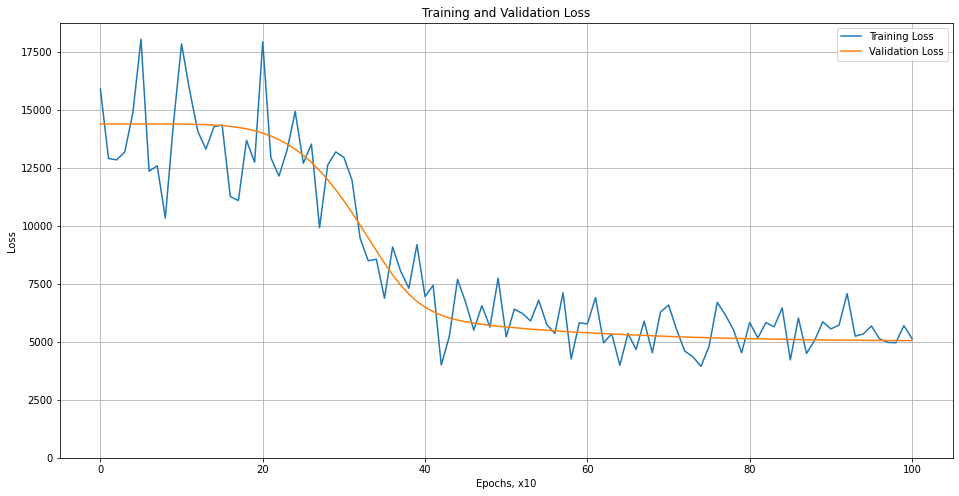

In [41]:
net_learn(net_large)

По графикам функции потерь видно, что самая большая модель с тремя скрытыми слоями обучается быстрее всего и с наименьшим RMSE. В дальнейшем мы будем использовать именно её. Вглянем на график факт-прогноз по этой модели.

In [42]:
# Дадим модели первые 20 значений из тестовой выборки
net_large.eval()

test_preds_first_20 = torch.flatten(net_large.forward(X_test_torch[:20]))
test_preds_first_20 = test_preds_first_20.detach().numpy().astype('int')

y_test_first_20 = y_test[:20]

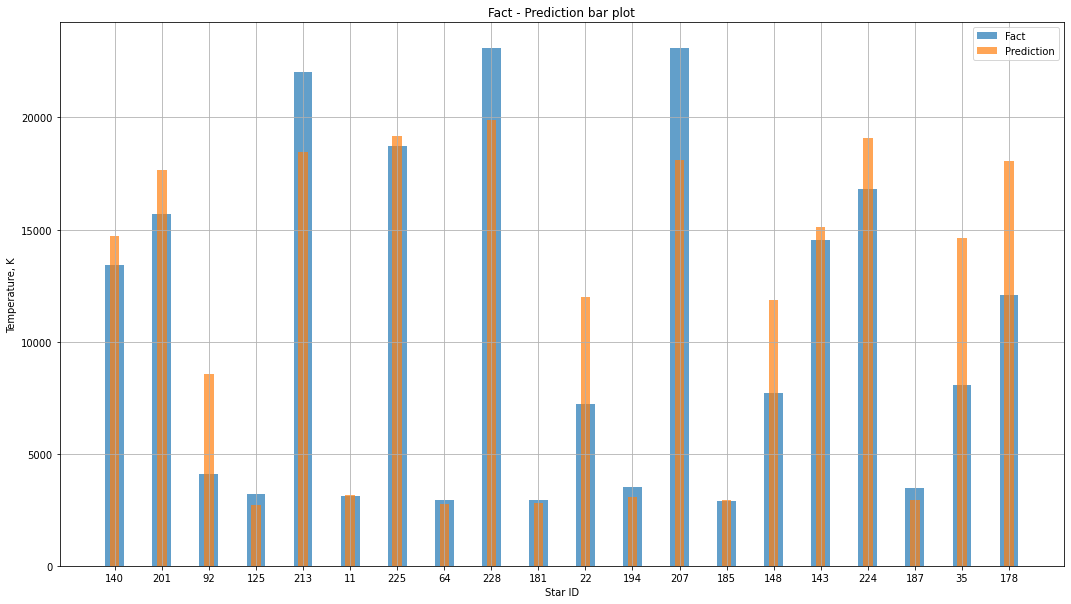

In [43]:
# Построим столбачтую диаграмму
plt.figure(figsize=(18,10))

X_axis = np.arange(len(test_preds_first_20))
X = y_test_first_20.index


plt.bar(X_axis, y_test_first_20, 0.4, alpha=0.7, label = 'Fact')
plt.bar(X_axis, test_preds_first_20, 0.2, alpha=0.7, label = 'Prediction')

plt.xticks(X_axis, X)
plt.xlabel("Star ID")
plt.ylabel("Temperature, K")
plt.title("Fact - Prediction bar plot")
plt.legend()
plt.grid()
plt.show()

### Вывод 

На диаграмме хорошо видно, что модель вполне уверенно и точно может предсказывать температуру в районе 2500К. Это красно-оранжевые звёзды. В нашем датасете они сильно преобладают. Проблемы у модели возникают, когда необходимо предсказать температуру более редких звёзд - белых и голубых. На изображении ниже видно, что данные звёзды сами по себе встречаются крайне редко.

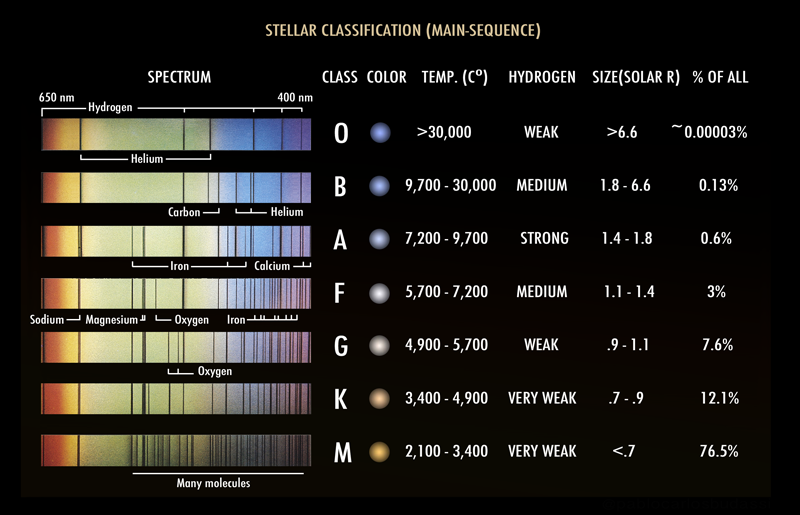

## Улучшение нейронной сети

За основу для улучшения мы возьмём `net_large`. Оставим прежними и не будем менять: количество слоёв, количество нейронов, функции активации, инициализация весов и коэффициентов.

Добавим в сеть `BatchNorm` и `Dropout`. Проверим несколько комбинаций.

### `BatchNorm` and `Dropout `

In [44]:
n_in_neurons = 10 

n_hidden_neurons_1 = 5
n_hidden_neurons_2 = 4
n_hidden_neurons_3 = 3
n_hidden_neurons_4 = 2

n_out_neurons = 1 

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(layer.bias, mean=0.5, std=0.5)

net_final_1 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.BatchNorm1d(n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.BatchNorm1d(n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.BatchNorm1d(n_hidden_neurons_3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.BatchNorm1d(n_hidden_neurons_4),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_4, n_out_neurons)
)

net_final_2 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.BatchNorm1d(n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.BatchNorm1d(n_hidden_neurons_3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.BatchNorm1d(n_hidden_neurons_4),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_4, n_out_neurons)
)

net_final_3 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.BatchNorm1d(n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.BatchNorm1d(n_hidden_neurons_3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.BatchNorm1d(n_hidden_neurons_4),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_4, n_out_neurons)
)

display(net_final_1.apply(init_weights))
display(net_final_2.apply(init_weights))
display(net_final_3.apply(init_weights))

Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=5, out_features=4, bias=True)
  (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=3, out_features=2, bias=True)
  (10): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=2, out_features=1, bias=True)
)

Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=5, out_features=4, bias=True)
  (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=3, out_features=2, bias=True)
  (10): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=2, out_features=1, bias=True)
)

Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=5, out_features=4, bias=True)
  (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=3, out_features=2, bias=True)
  (10): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=2, out_features=1, bias=True)
)

The last RMSE: 5028.1236204460565


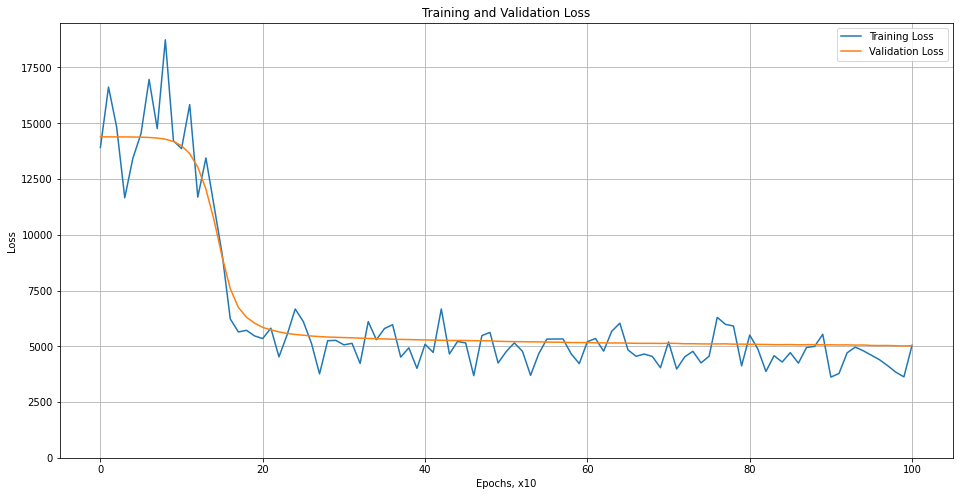

In [45]:
# Только BatchNorm
net_learn(net_final_1)

The last RMSE: 5109.792762497223


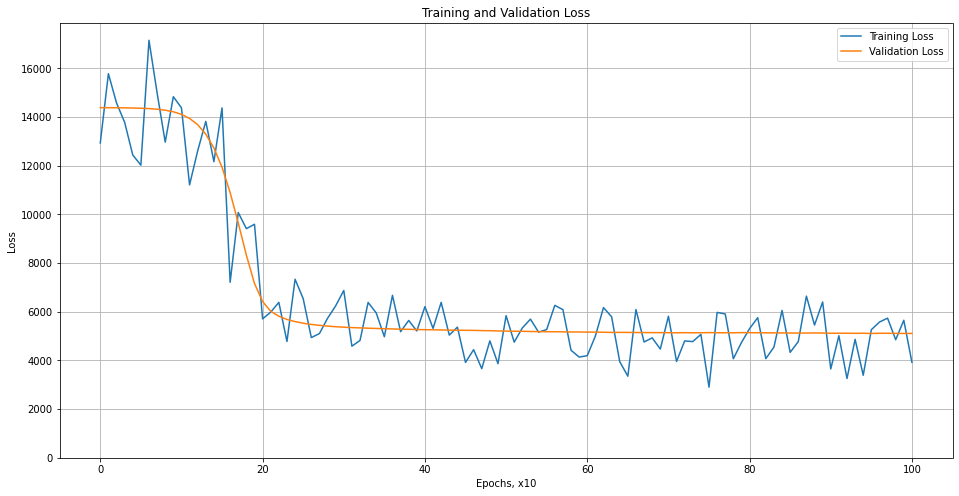

In [46]:
# После первого слоя DropOut p=0.2. После остальных слоёв BatchNorm
net_learn(net_final_2)

The last RMSE: 14387.659805958658


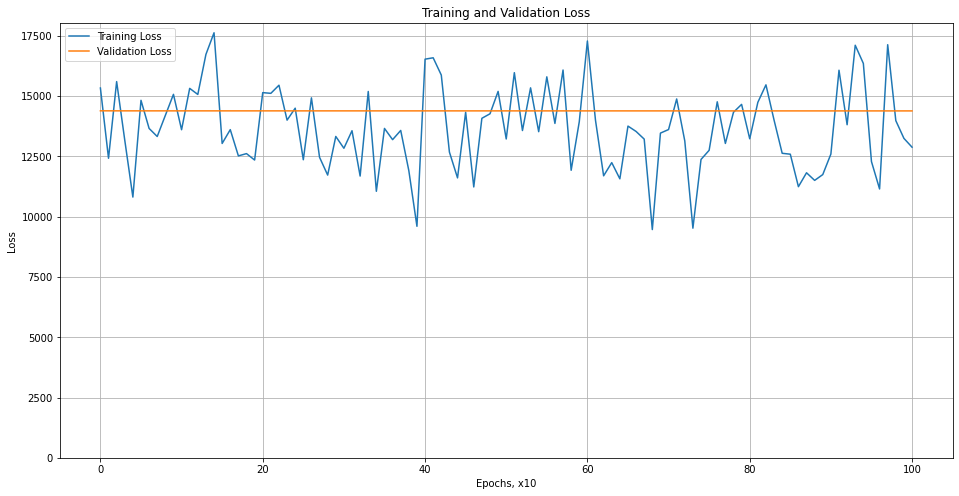

In [47]:
# После первого слоя DropOut p=0.5. После остальных слоёв BatchNorm
net_learn(net_final_3)

#### Вывод 

На графиках отчётливо видно, что сети стали обучаться гораздо быстрее с `BatchNorm`. `DropOut` в зависимости от коэффициента может оказывать как позитивное, так и негативное влияние. Качественного улучшения метрик добиться не удалось. RMSE составляет около 5000.

### Batch size

Попробуем изменить размер батча. За основу возьмём модель `net_final_1`. Пересоздадим модель, чтобы сбросить параметры.

Значения по умолчанию для функции `net_learn`:
* `batch_size=64`
* `num_epochs=1000`
* `eval_epoch=10`
* `learning_rate=1e-3`


In [48]:
# Функция для инициализации сети
def init_model():
    n_in_neurons = 10 

    n_hidden_neurons_1 = 5
    n_hidden_neurons_2 = 4
    n_hidden_neurons_3 = 3
    n_hidden_neurons_4 = 2

    n_out_neurons = 1 

    def init_weights(layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
            nn.init.normal_(layer.bias, mean=0.5, std=0.5)

    net_final = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.BatchNorm1d(n_hidden_neurons_1),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.BatchNorm1d(n_hidden_neurons_2),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
        nn.BatchNorm1d(n_hidden_neurons_3),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
        nn.BatchNorm1d(n_hidden_neurons_4),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_4, n_out_neurons)
    )

    net_final.apply(init_weights)
    
    return net_final

The last RMSE: 4286.782134469256


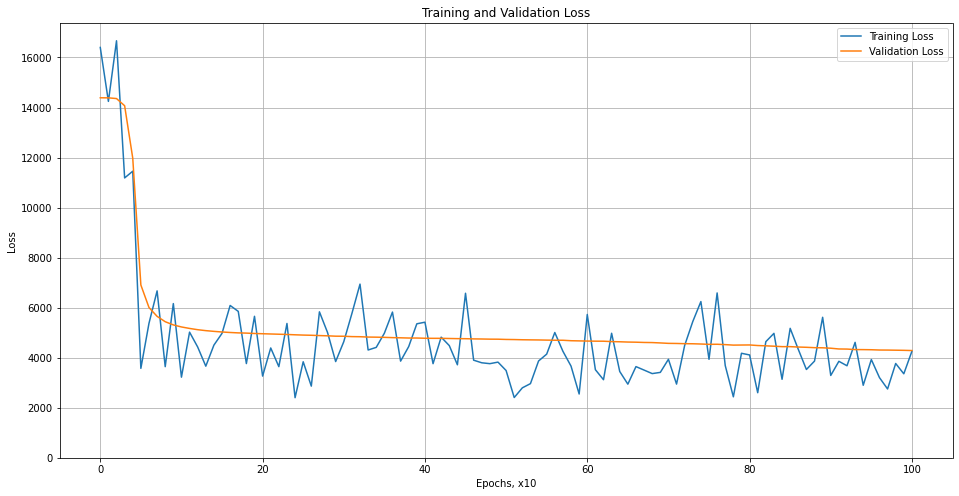

In [49]:
net_final = init_model()
net_learn(net_final, batch_size=16)

The last RMSE: 14386.177886284051


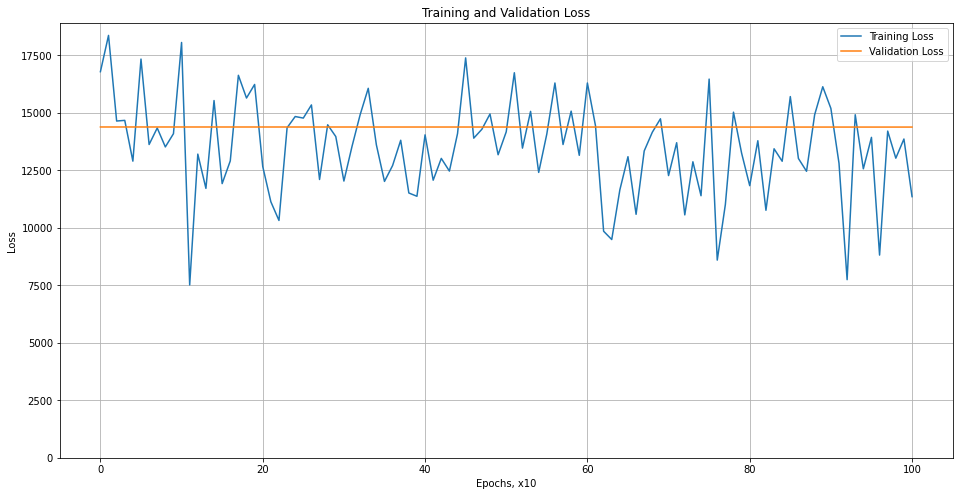

In [50]:
net_final = init_model()
net_learn(net_final, batch_size=32)

The last RMSE: 9323.955908691349


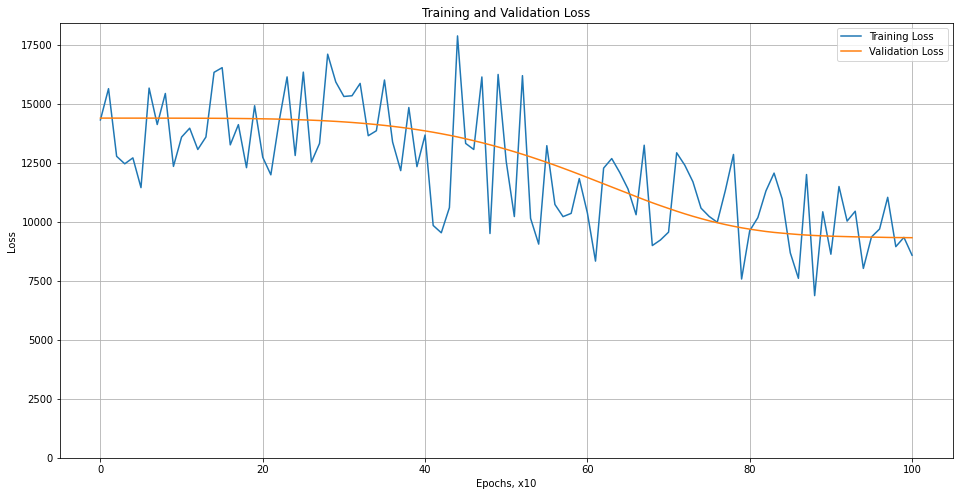

In [51]:
net_final = init_model()
net_learn(net_final, batch_size=64)

The last RMSE: 5106.177344950184


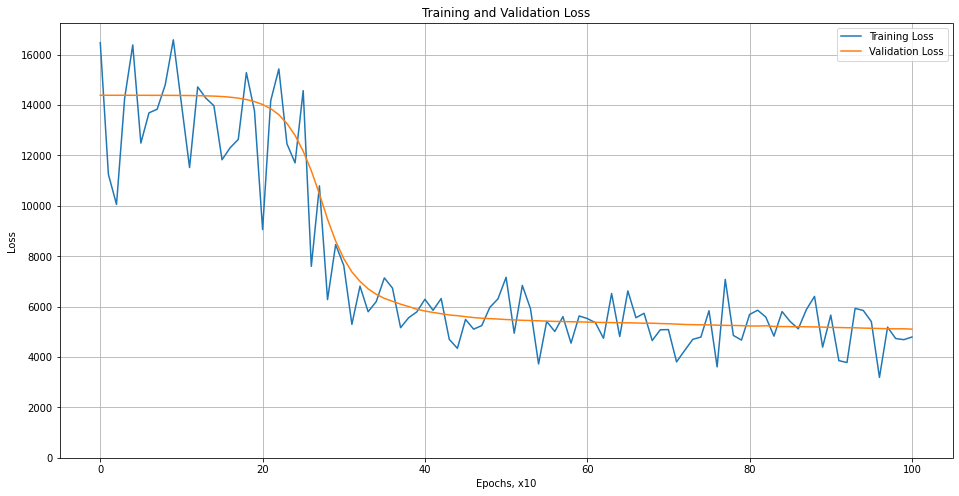

In [52]:
net_final = init_model()
net_learn(net_final, batch_size=128)

The last RMSE: 14388.989201895578


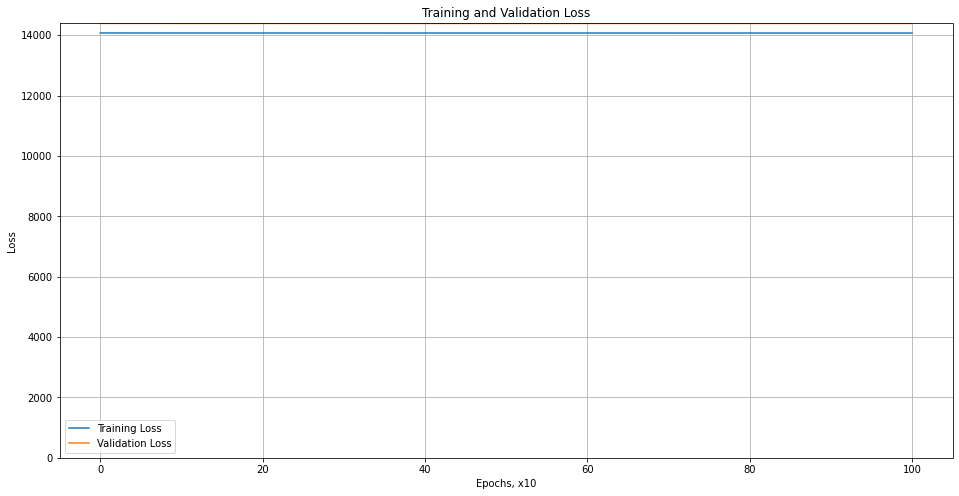

In [53]:
net_final = init_model()
net_learn(net_final, batch_size=200)

#### Вывод 

Качественное улучшение метрики при `batch_size=16`.

### Learning Rate 

Попробуем уменьшить `learning_rate` с размерами батча 16, 32, 64, 128 и 200. Используем следующие значения `learning_rate`: `1e-2`, `1e-4`, `3e-4`.

#### `1e-2 `

The last RMSE: 4136.452396868789


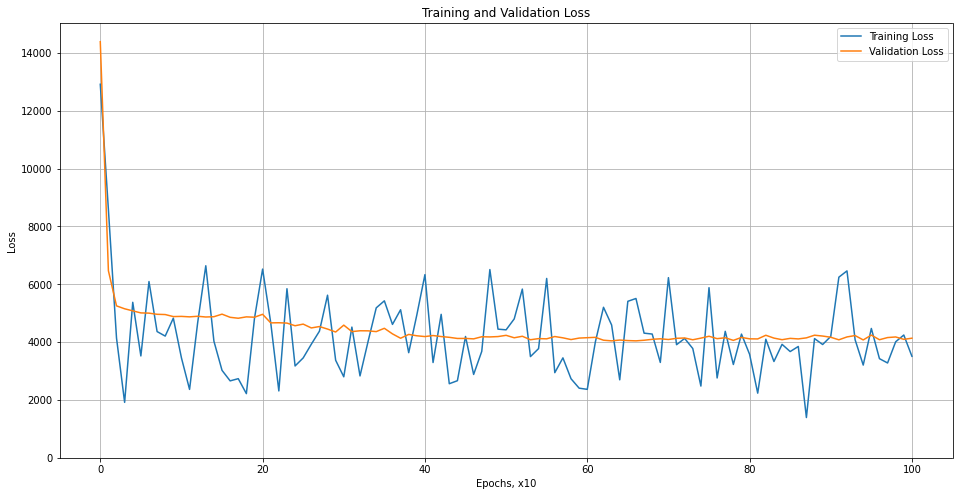

In [54]:
net_final = init_model()
net_learn(net_final, batch_size=16, learning_rate=1e-2)

The last RMSE: 5093.433947158469


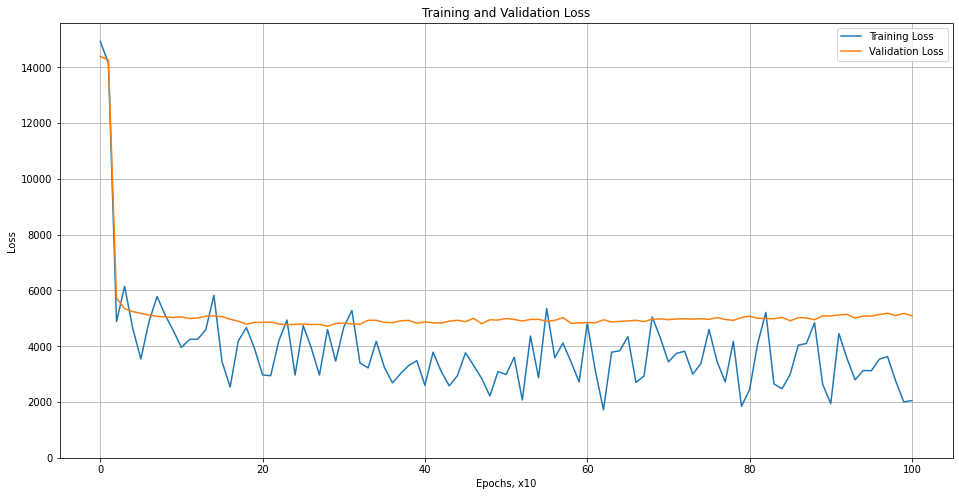

In [55]:
net_final = init_model()
net_learn(net_final, batch_size=32, learning_rate=1e-2)

The last RMSE: 4548.484590275398


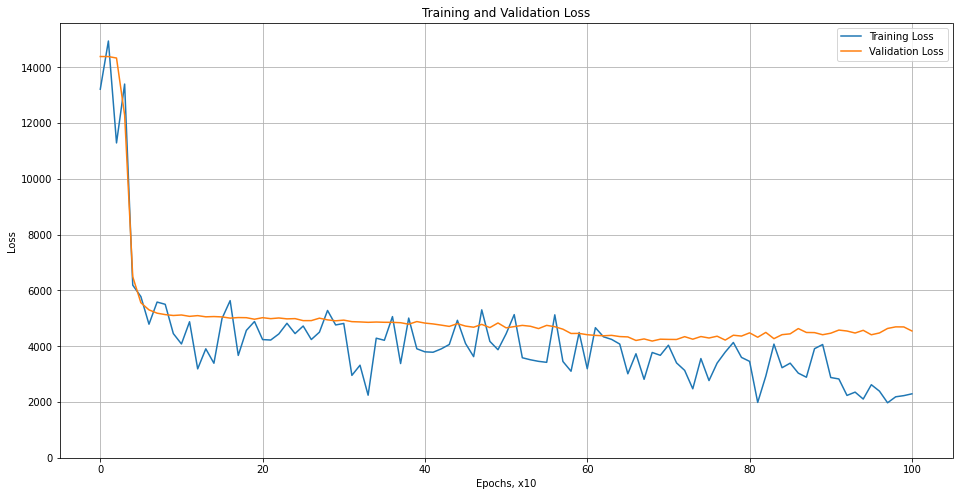

In [56]:
net_final = init_model()
net_learn(net_final, batch_size=64, learning_rate=1e-2)

The last RMSE: 14375.43771079053


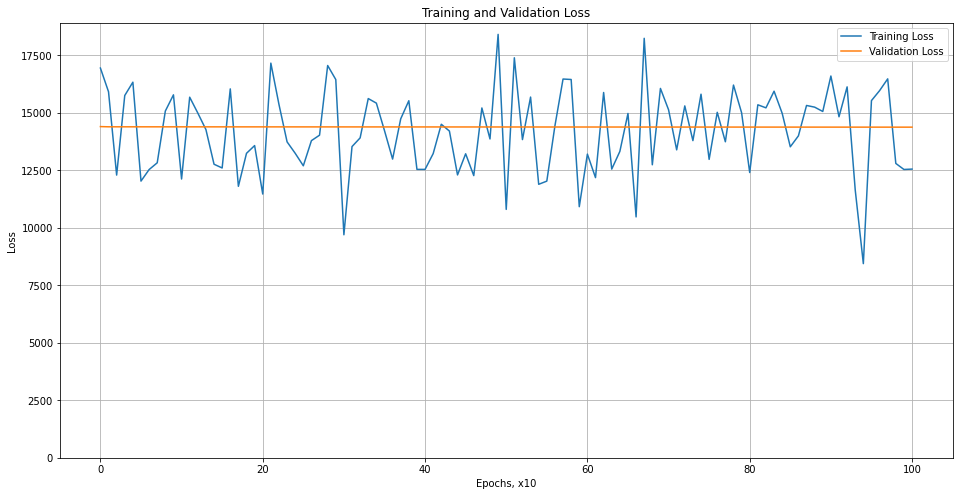

In [57]:
net_final = init_model()
net_learn(net_final, batch_size=128, learning_rate=1e-2)

The last RMSE: 10536.958778293578


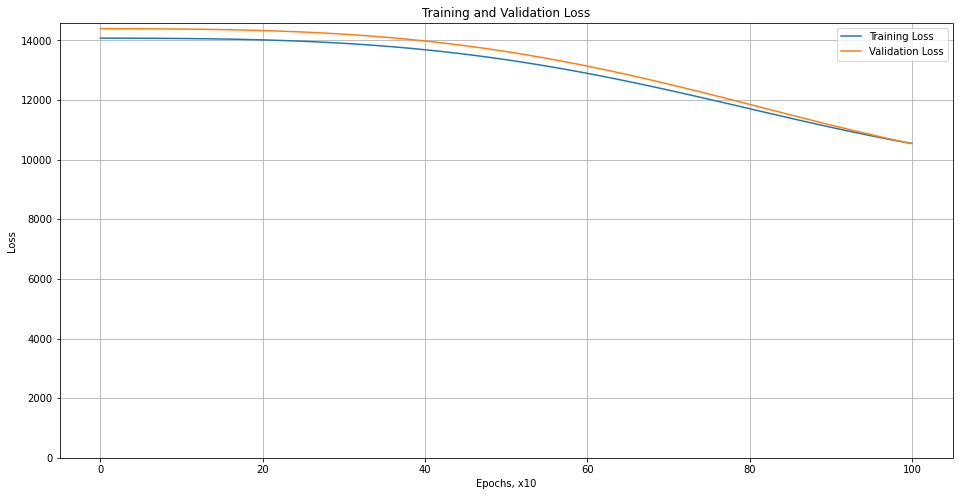

In [58]:
net_final = init_model()
net_learn(net_final, batch_size=200, learning_rate=1e-2)

#### `1e-4`

The last RMSE: 14388.98986270715


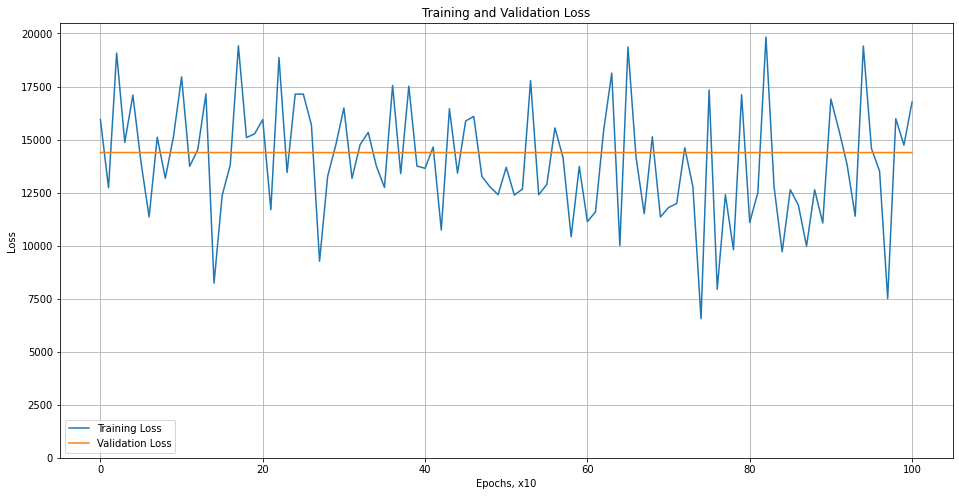

In [59]:
net_final = init_model()
net_learn(net_final, batch_size=16, learning_rate=1e-4)

The last RMSE: 14388.366301998474


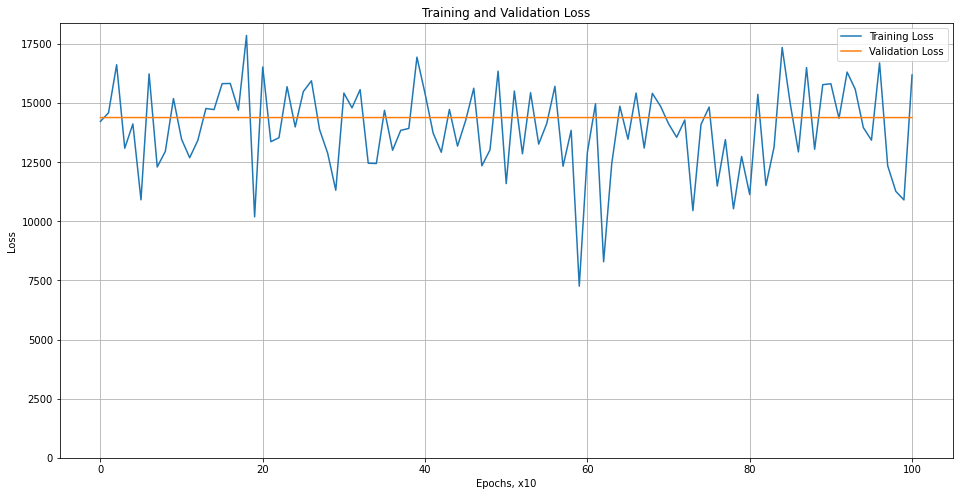

In [60]:
net_final = init_model()
net_learn(net_final, batch_size=32, learning_rate=1e-4)

The last RMSE: 14331.517148247098


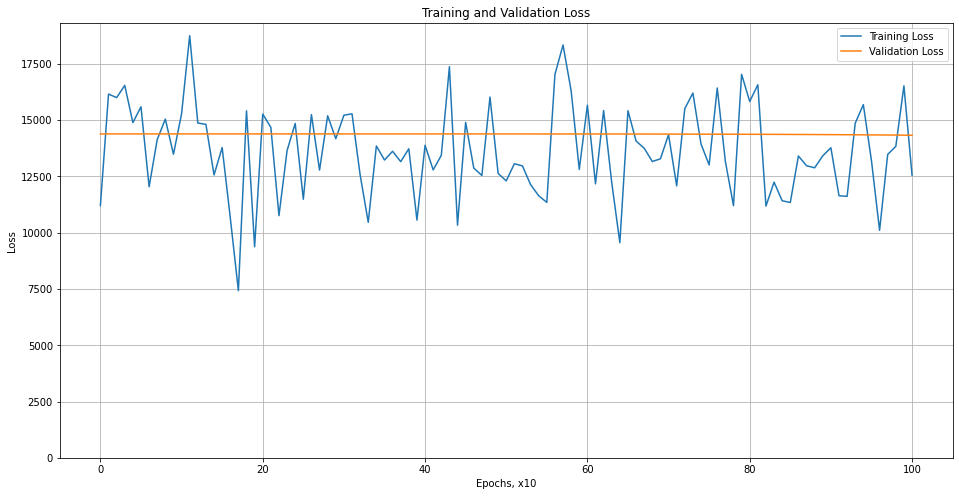

In [61]:
net_final = init_model()
net_learn(net_final, batch_size=64, learning_rate=1e-4)

The last RMSE: 14388.575805055742


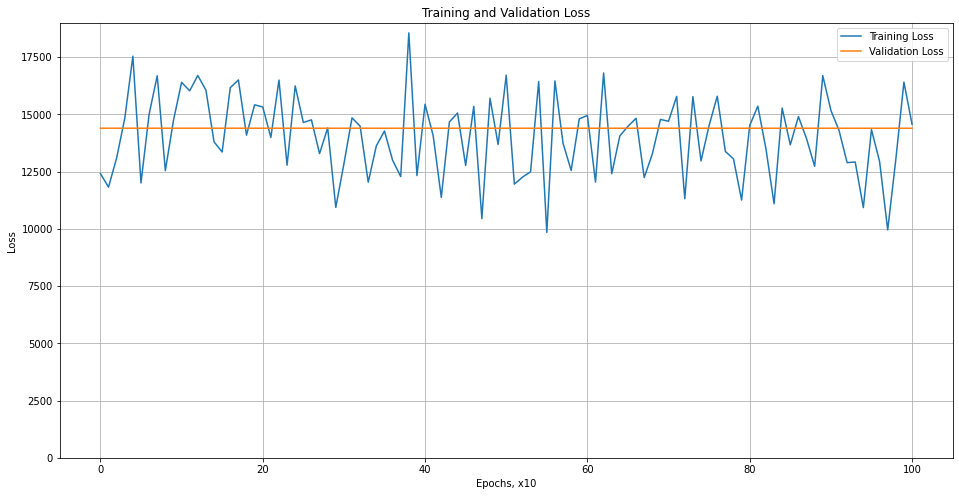

In [62]:
net_final = init_model()
net_learn(net_final, batch_size=128, learning_rate=1e-4)

The last RMSE: 14379.347681175941


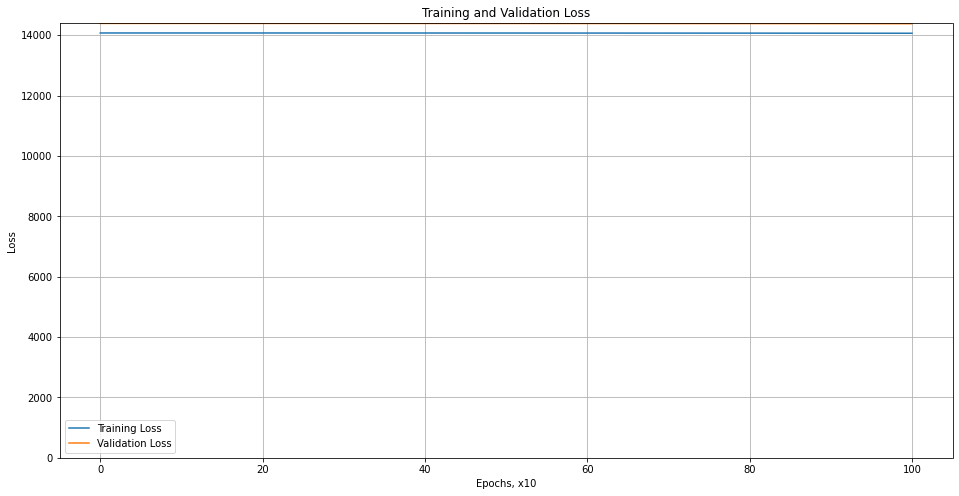

In [63]:
net_final = init_model()
net_learn(net_final, batch_size=200, learning_rate=1e-4)

#### `3e-4`

The last RMSE: 5047.260121755376


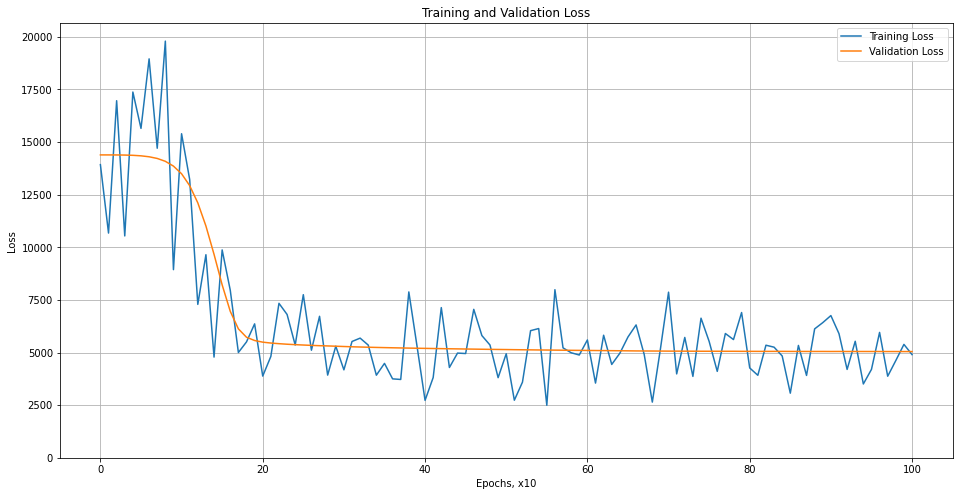

In [64]:
net_final = init_model()
net_learn(net_final, batch_size=16, learning_rate=3e-4)

The last RMSE: 5110.217920111868


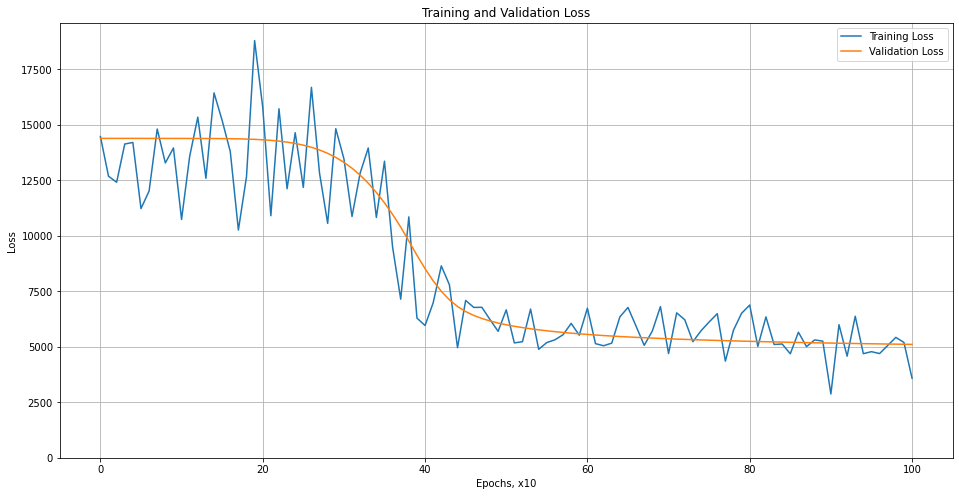

In [65]:
net_final = init_model()
net_learn(net_final, batch_size=32, learning_rate=3e-4)

The last RMSE: 5615.162637319735


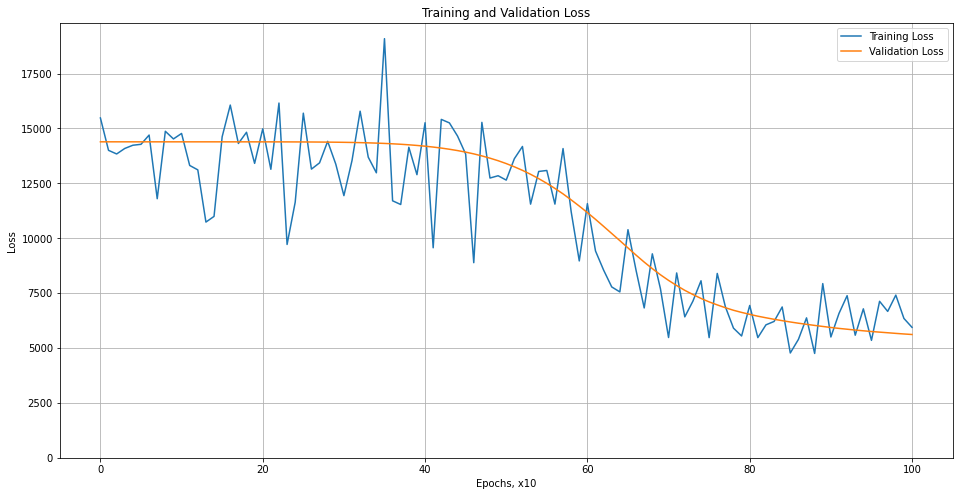

In [66]:
net_final = init_model()
net_learn(net_final, batch_size=64, learning_rate=3e-4)

The last RMSE: 6141.3946862067305


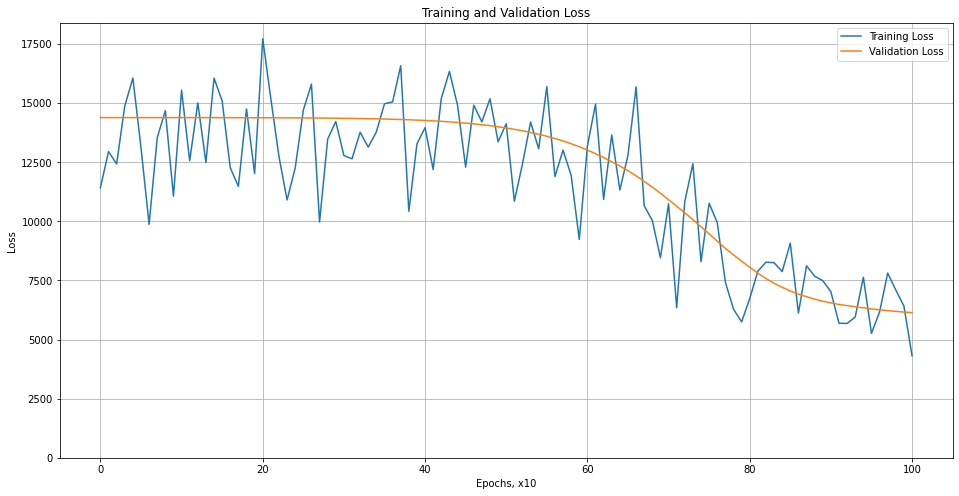

In [67]:
net_final = init_model()
net_learn(net_final, batch_size=128, learning_rate=3e-4)

The last RMSE: 14373.326294391552


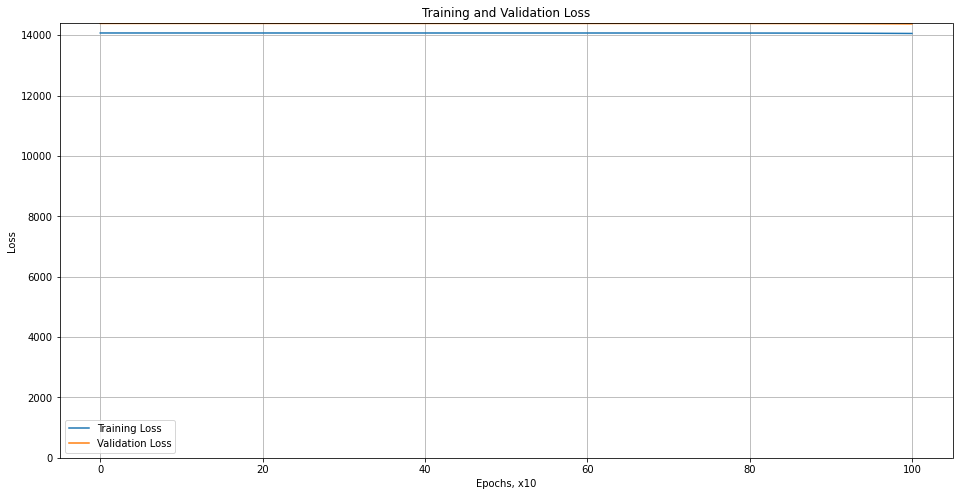

In [68]:
net_final = init_model()
net_learn(net_final, batch_size=200, learning_rate=3e-4)

#### Вывод

Скорость обучения `lr=1e-2` показала себя лучше всего. Удалось добиться целевого значения метрики RMSE. 
На скоростях обучения `lr=3e-4` и `lr=1e-4` модель обучается очень плохо или не обучается совсем. 

Наиболее оптимальными выглядят параметры `batch_size=16, learning_rate=1e-2`. При `batch_size=32` и `batch_size=64` происходит переобучение модели - расстояние между функциями потерь на учебных и тестовых данных увеличивается. Training Loss становится гораздо меньше Validation Loss.

### Learning Rate p.2 

Проверим обучение модели со следующими гиперпараметрами:
* `batch_size=16, learning_rate=1e-1`
* `batch_size=16, learning_rate=3e-2`
* `batch_size=16, learning_rate=9e-3`
* `batch_size=128, learning_rate=3e-4, num_epochs=2000`

Попробуем выяснить оптимальное значение `learning_rate` и имеет ли смысл обучать модель медленнее, большими батчами, но на большем количестве эпох.

The last RMSE: 5992.5486558185785


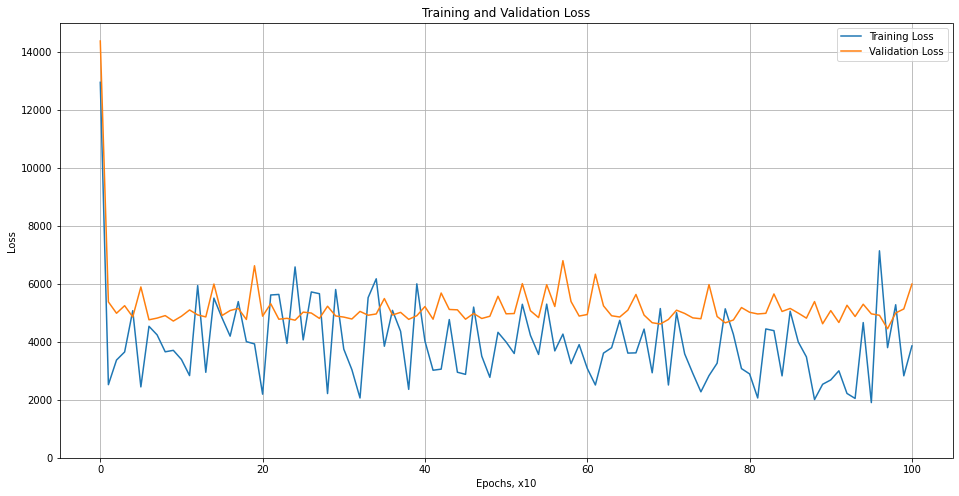

In [69]:
net_final = init_model()
net_learn(net_final, batch_size=16, learning_rate=1e-1)

The last RMSE: 4628.069384847595


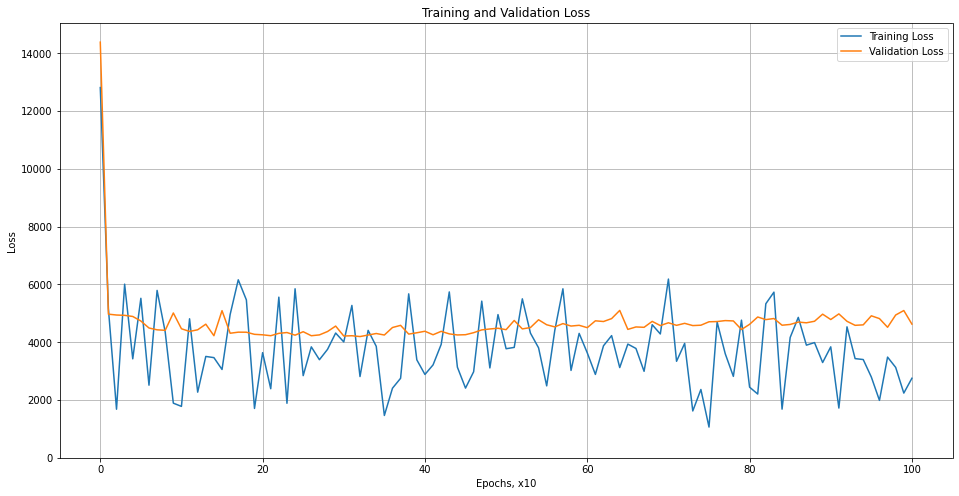

In [70]:
net_final = init_model()
net_learn(net_final, batch_size=16, learning_rate=3e-2)

The last RMSE: 5217.35610805862


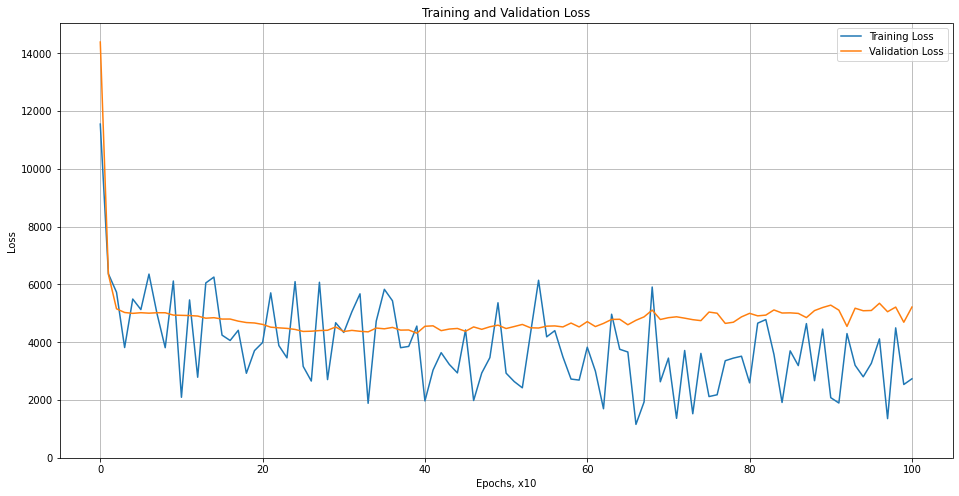

In [71]:
net_final = init_model()
net_learn(net_final, batch_size=16, learning_rate=9e-3)

The last RMSE: 14389.642035240147


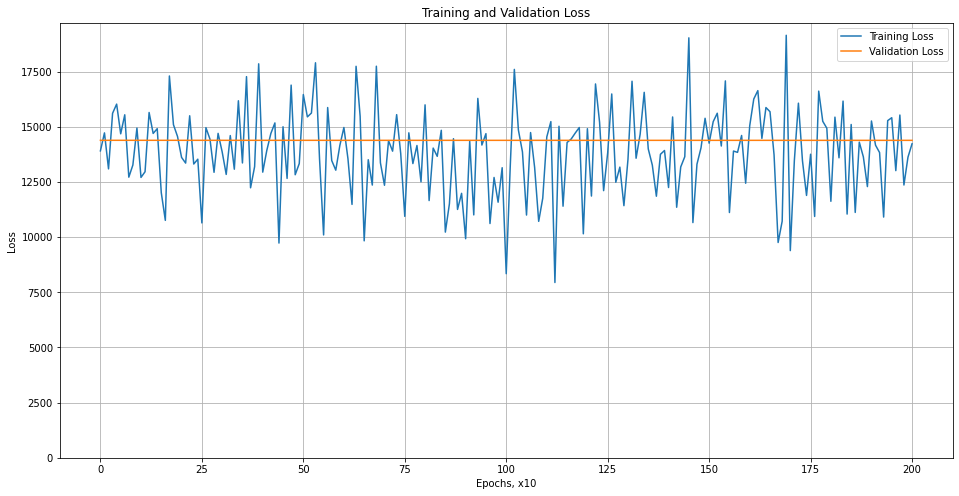

In [72]:
net_final = init_model()
net_learn(net_final, batch_size=128, learning_rate=3e-4, num_epochs=2000)

#### Вывод 

В результате дополнительных проверок стало ясно, что скорость обучения `1e-2` при `batch_size=16` является оптимальным значением, с наименьшим расхождением между тестовой и валидационной метрикой. Увеличение количества эпох совместно с увеличением размера батча не принесло положительных результатов.

### Улучшение нейронной сети. Вывод 

The last RMSE: 4483.504308513643


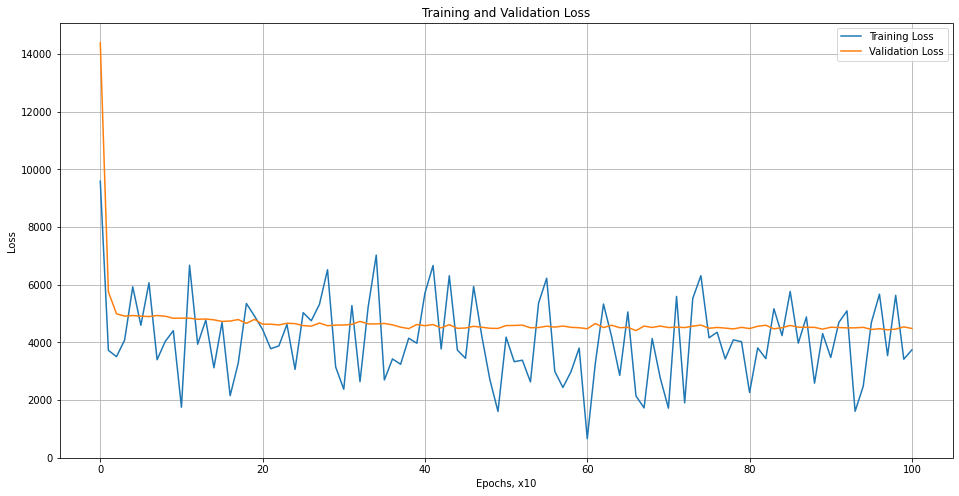

In [79]:
# Берём лучшую модель
net_final = init_model()
net_learn(net_final, batch_size=16, learning_rate=1e-2)

In [80]:
# Дадим модели первые 20 значений из тестовой выборки
net_final.eval()

test_preds_final = torch.flatten(net_final.forward(X_test_torch[:20]))
test_preds_final = test_preds_final.detach().numpy().astype('int')

y_test_first_20 = y_test[:20]

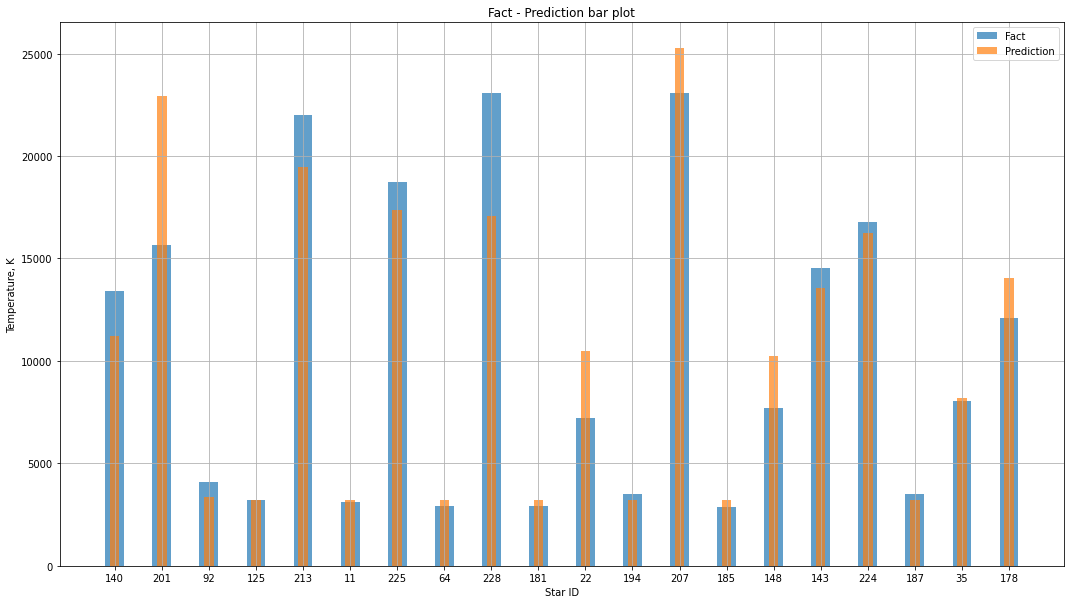

In [81]:
# Построим столбачтую диаграмму
plt.figure(figsize=(18,10))

X_axis = np.arange(len(test_preds_first_20))
X = y_test_first_20.index


plt.bar(X_axis, y_test_first_20, 0.4, alpha=0.7, label = 'Fact')
plt.bar(X_axis, test_preds_final, 0.2, alpha=0.7, label = 'Prediction')

plt.xticks(X_axis, X)
plt.xlabel("Star ID")
plt.ylabel("Temperature, K")
plt.title("Fact - Prediction bar plot")
plt.legend()
plt.grid()
plt.show()

В результате перебора гиперпараметров нам удалось обучить нейросеть с целевой метрикой RMSE > 4500. Гиперпараметры данной модели:
* `batch_size=16`
* `learning_rate=1e-2`
* `num_epochs=1000`

На диаграмме видно, что модель хорошо предсказывает температуру до 5000К. С температурой выше этого значение у модели иногда возникают проблемы из-за недостатка данных для обучения.

## Выводы по проекту

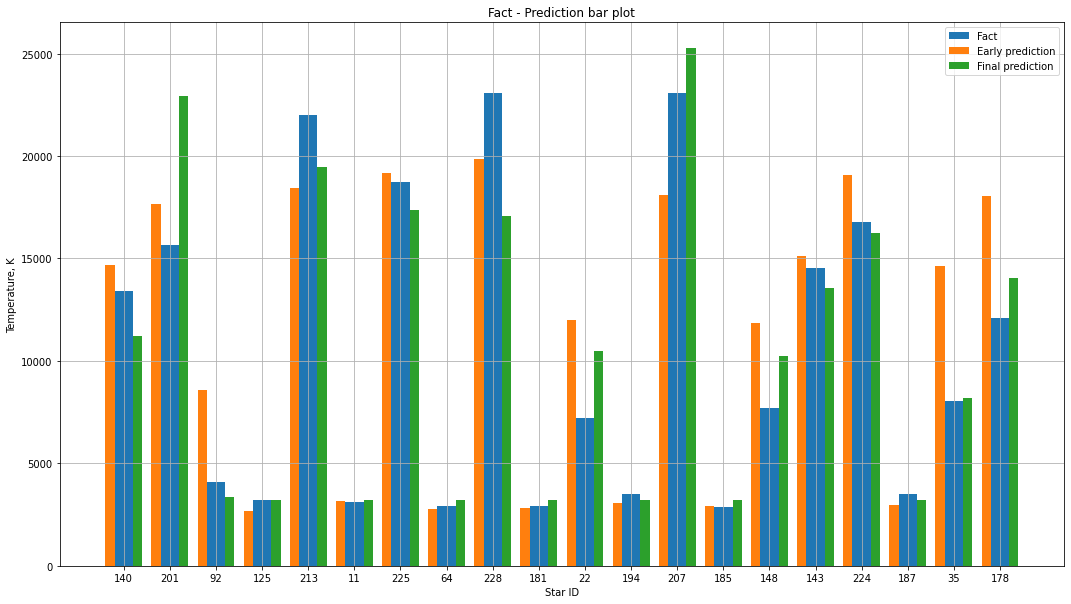

In [82]:
# Итоговая столбачатая диаграмма Факт-Прогноз
plt.figure(figsize=(18,10))

X_axis = np.arange(len(test_preds_first_20))
X = y_test_first_20.index


plt.bar(X_axis, y_test_first_20, 0.4, alpha=1, label = 'Fact')
plt.bar(X_axis -0.3, test_preds_first_20, 0.2, alpha=1, label = 'Early prediction')
plt.bar(X_axis +0.3, test_preds_final, 0.2, alpha=1, label = 'Final prediction')

plt.xticks(X_axis, X)
plt.xlabel("Star ID")
plt.ylabel("Temperature, K")
plt.title("Fact - Prediction bar plot")
plt.legend()
plt.grid()
plt.show()

Данная диаграмма позволяет наглядно сравнить значения предсказаний от базовой модели и от оптимизированной модели. Обе модели не очень уверенно предсказывают температуры выше 5000К, но оптимизированная модель делает это более точно. Итоговая таблица со свойствами моделей и гиперпараметрами:

|                                           | Базовая модель | Оптимизированная модель |
| ----------------------------------------- | -------------- | ----------------------- |
| Кол-во нейронов на входном слое           | 10             | 10                      |
| Кол-во нейронов на 1-ом скрытом слое      | 5              | 5                       |
| Кол-во нейронов на 2-ом скрытом слое      | 4              | 4                       |
| Кол-во нейронов на 3-ом скрытом слое      | 3              | 3                       |
| Кол-во нейронов на выходном слое          | 2              | 2                       |
| Кол-во нейронов на выходе                 | 1              | 1                       |
| Функции активации                         | ReLU           | ReLU                    |
| После каждого слоя используется BatchNorm | Нет            | Да                      |
| Batch size                                | 64             | 16                      |
| Learning rate                             | 1e-3           | 1e-2                    |
| Number of epochs                          | 1000           | 1000                    |
| RMSE < 4500                               | Нет            | Да                      |